<a href="https://colab.research.google.com/github/AloofBuddha/neural-nets-zero-to-hero/blob/main/makemore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
words = open('names.txt', 'r').read().splitlines()

words[:10]

# 32k example
len(words)

# min length 2
min(len(w) for w in words)

# max length 15
max(len(w) for w in words)

# we want to think about the bigrams - what is the frequency of any given letter being followed by another letter

# break down word to bigrams
b = {} # keep track of counts
for w in words:
    # special characters for 'start' / 'end'
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

counts = sorted(b.items(), key=lambda kv: -kv[1])


In [36]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [37]:
# bigram count matrix
N = torch.zeros((27, 27), dtype=torch.int32)

# list of chars a-z
chars = sorted(list(set(''.join(words))))

# lookup table char -> index in a-z (including '.' delimiter character for first)
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

# we want a index -> char table as well
itos = {i: s for s,i in stoi.items()}

for w in words:
    # special characters for 'start' / 'end'
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        bigram = (ch1, ch2)
        N[ix1, ix2] += 1

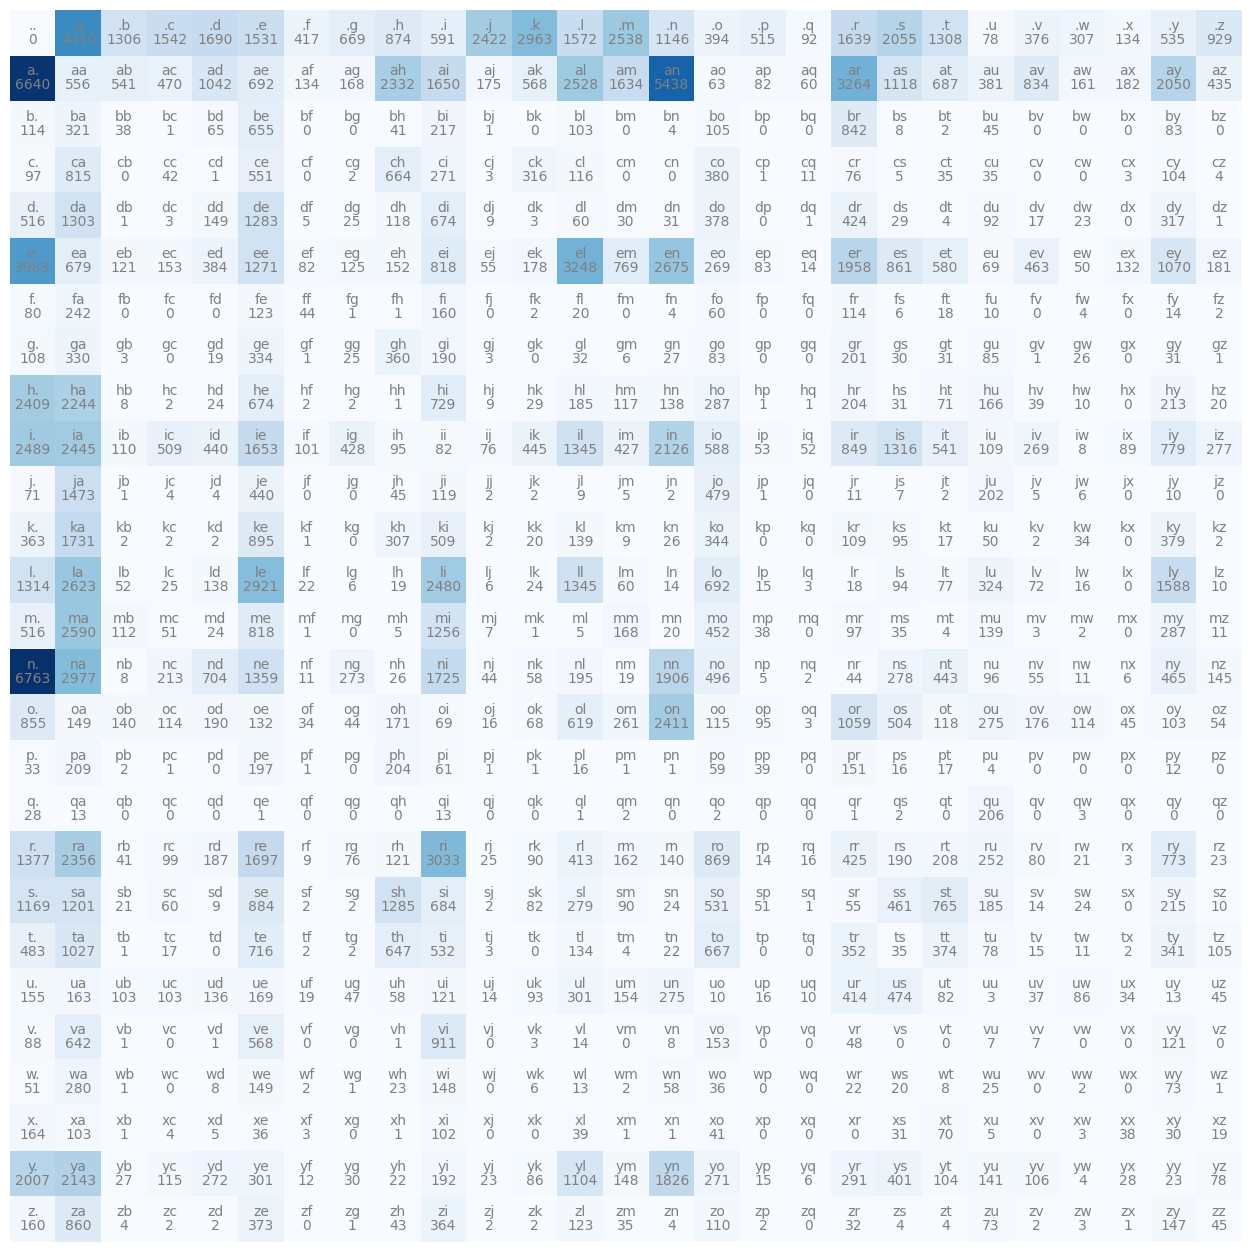

In [38]:
# visualizer - we have counts for our entire data set that captures all the bigrams, including metacharacters like 'start token' and 'end token'

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

Even the most basic analysis can tell us things like:

- The most frequent start letter is 'a'
- the most frequent end letters are 'a' and 'n'
- 'an' is our most frequent bigram
- some of our data points are pointless - a word will never start with the `<E>` token for example, nor end with `<S>` - room to optimize!

N

In [39]:
# N is our 27 x 27 nigram tensor
N
# our first row represents the counts for [aa, ab, ac, ad ... a.]
N[0]

# cast our sample into floats (was int32) and normalize by total counts
p = N[0].float()
p /= p.sum()
# p now represents the frequencies of a followed by another character, as compared against all characters, summing in total to 1
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [40]:
# for what we want to do next we need predictable random #s
g = torch.Generator().manual_seed(2147483647) # manual seed is just to make this 'trackable' and not change on each run
p = torch.rand(3, generator=g)
# p holds 3 random #s now between 0 and 1
p = p / p.sum()
# p now equals 3 random normalized values (sum to 1)
print(p)
# now we can use this random distro split in 3 to produce data matching that distro using torch.multinomial
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g)
# by setting the sample size to 1 we can now get a single value from [0, 1, 2] with the generated distribution
ix.item()

tensor([0.6064, 0.3033, 0.0903])


0

torch.Size([27, 27])


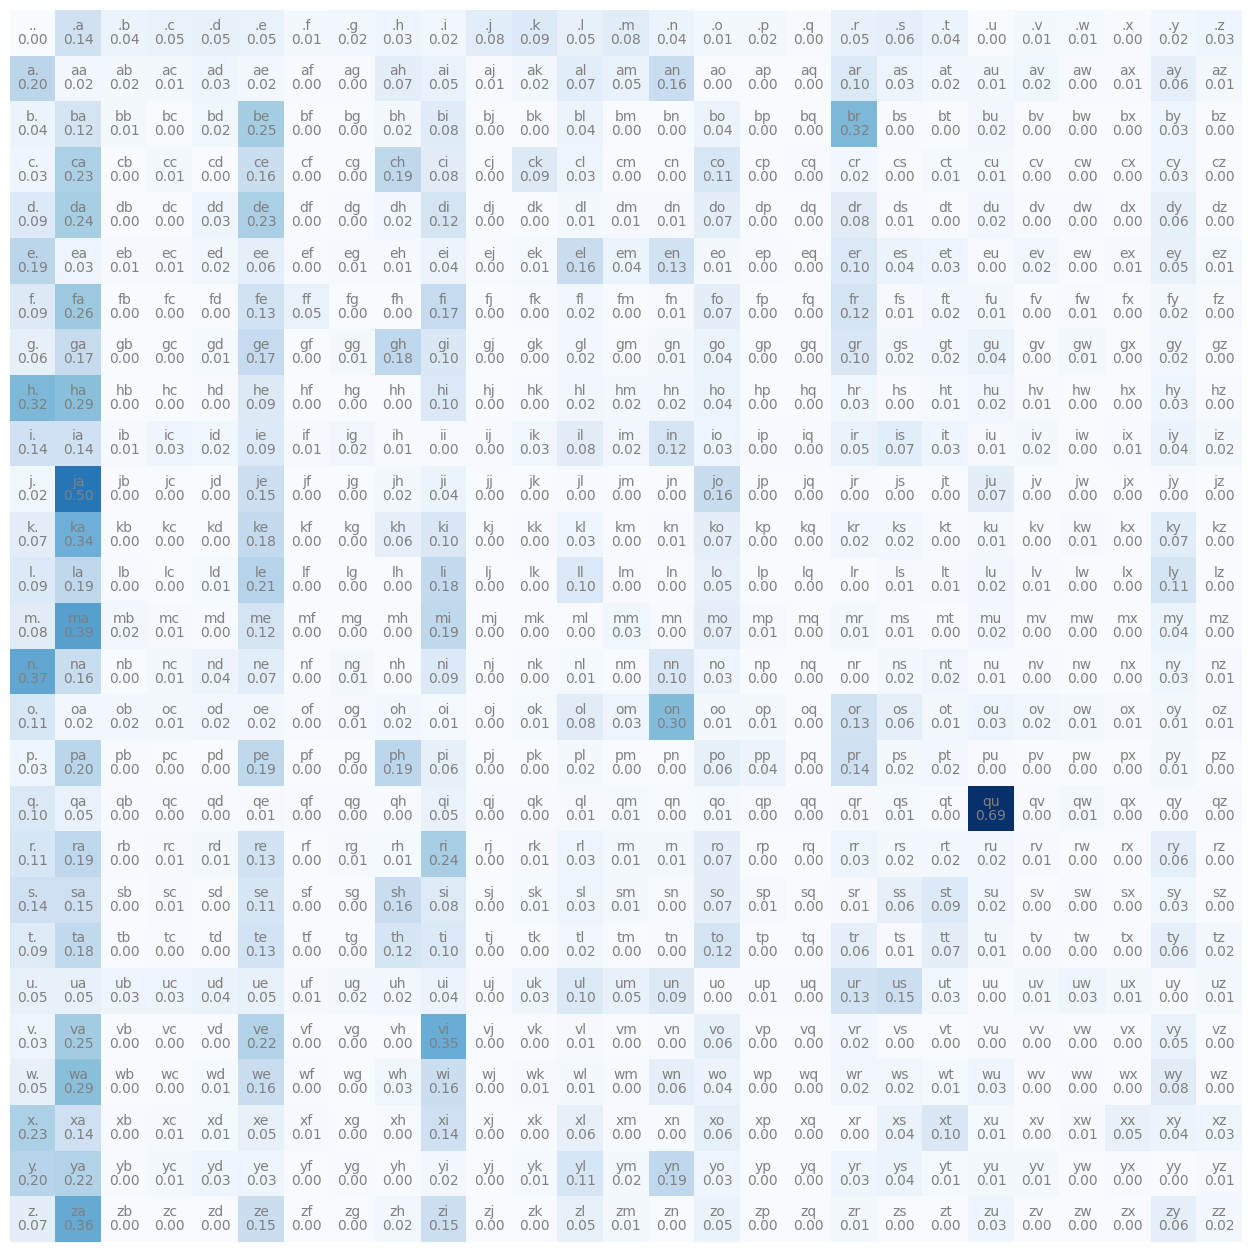

In [41]:
# optimization - turn out predictions into a tensor instead of doing it by hand each time
# N+1 is model smoothing so nll is never -Infinity
P = (N+1).float()

# understanding sum/keepdim
# S = P.sum() # will sum the entire 27 x 27 matrix and return a scalar
# S = P.sum(0) # will sum the matrix by col and return a 27 elem array
# S = P.sum(1) # will sum the matrix by row and return a 27 elem array
# S = P.sum(0, keepdim=True) # will sum the matrix by col and return a 1 x 27 matrix
# S = P.sum(1, keepdim=True) # will sum the matrix by row and return a 27 x 1 matrix

# ultimately this is what we want for matrix multipliction because it is transposed
# remember - broadcasting rules
# 27 x 27
# 27 x 1
# our final matrix S has 27 cols, each with a single row holding the sum of the equivalent row at P
print(P.shape)

# each row represents a % frequency for that letter followed by all other letters (normalized)
P /= P.sum(1, keepdim=True)


# frequency per letter map
plt.figure(figsize=(16,16))
plt.imshow(P, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, "{:.2f}".format(P[i, j].item()), ha="center", va="top", color='gray')
plt.axis('off');

In [42]:
g = torch.Generator().manual_seed(2147483647)

# first for a baseline let's see how our bigram model performs with uniform distribution
# (as if every letter is as likely to follow as any other)

names = []

for i in range(30):
  ix = 0
  name = []

  while True:
    p = torch.ones(27) / 27.0
    # given that frequency distribution, get a random index
    ix = torch.multinomial(p, num_samples=1,
                           replacement=True, generator=g).item()
    name.append(itos[ix])
    # stop when the next random letter chosen is an end char symbol (. = <E>)
    if ix == 0:
      names.append(''.join(name))
      break

# wow, these are some pretty bad names. it has no concept of length
names

['juwjdvdipkcqaz.',
 'p.',
 'cfqywocnzqfjiirltozcogsjgwzvudlhnpauyjbilevhajkdbduinrwibtlzsnjyievyvaftbzffvmumthyfodtumjrpfytszwjhrjagq.',
 'coreaysezocfkyjjabdywejfmoifmwyfinwagaasnhsvfihofszxhddgosfmptpagicz.',
 'rjpiufmthdt.',
 'rkrrsru.',
 'iyumuyfy.',
 'mjekujcbkhvupwyhvpvhvccragr.',
 'wdkhwfdztta.',
 'mplyisbxlyhuuiqzavmpocbzthqmimvyqwat.',
 'f.',
 '.',
 'ndxjxfpvslqtikyzsaloevgvvnundewkfmbjzqegruxiteaxchwtmurzsodridcdznojvaliypvrghvxtezrwguciqqvywhqelv.',
 'viosvhibdhnceukgmtmwboscnbzoiwupnwnpipixtewbgsgyewfdacbfcxrvjypkmsbranmjrdsydotafvkdkbdepihzpwzsqdab.',
 'vfuolwbasrtugttbiqbujfdtskceqjtcdlcndfujqllsppgkltalmlokdmsl.',
 'fddmxjv.',
 'mfsgxmw.',
 'vdihkvngtojvrdsyqivcob.',
 'uziengogtjvnvqgfjtkqufrxfjlwglykiiluohgnoiuwzylq.',
 'fsgircvmhtipagkxwvjypnsriadmfujnlkcicvatjvryzeljxkbrlrjsp.',
 'puybxzhwuejbiotzqpxrkbhhhgsivfjblaklxoivwqjpdkucftazqgwslvrvqcqmbadayrgufbalqdoumwytowbzqzrvbddvlhqn.',
 'kvhztsmltmpcxnikfn.',
 'inzastwohtcyonakisemrtfxwwlsxihficdlxfkdxjljagkjmeifigffkmc

In [43]:
g = torch.Generator().manual_seed(2147483647)

# now let's apply this to our bigram problem
# start at 0 (. = <S>)
names = []

for i in range(30):
  ix = 0
  name = []

  while True:
    p = P[ix]
    # given that frequency distribution, get a random index
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    name.append(itos[ix])
    # stop when the next random letter chosen is an end char symbol (. = <E>)
    if ix == 0:
      names.append(''.join(name))
      break

names

['junide.',
 'janasah.',
 'p.',
 'cony.',
 'a.',
 'nn.',
 'kohin.',
 'tolian.',
 'juee.',
 'ksahnaauranilevias.',
 'dedainrwieta.',
 'ssonielylarte.',
 'faveumerifontume.',
 'phynslenaruani.',
 'core.',
 'yaenon.',
 'ka.',
 'jabdinerimikimaynin.',
 'anaasn.',
 'ssorionsush.',
 'dgossmitan.',
 'il.',
 'le.',
 'pann.',
 'that.',
 'janreli.',
 'isa.',
 'dyn.',
 'rijelumemahaunayaleva.',
 'cararr.']


these names are a bit better just because of the bigram frequency approach

names are only so long and often start or end with an a or d as the model predicts

but these don't actually read like names, especially the single letter ones

How can we *train* our model to get better results using NN?

Well first things first we need a way to measure our model's performance - NLL

In [44]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)
log_likelihood = 0.0
n = 0

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


Now let's cast our bigram model into the language of neural nets

In [45]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs, ys

. e
e m
m m
m a
a .


(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

our x -> y are both represented as integer mappings, so ".emma" = [value for . (0), value for 'e' (5) ...]

we have a total of 27 characters

integers don't make so much sense to feed as the value into the input layer of a NN so we will utilize 'one hot encoding'

in one hot encoding we represent the entire datatype as an array of length 27 and 0 for all indices except the one that matches

so e = 5 = [0 0 0 0 1 0 0 0 ...]

In [46]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

torch.float32

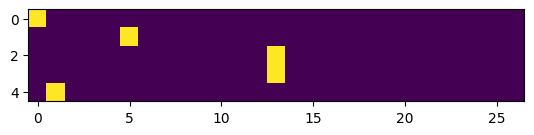

In [47]:
plt.imshow(xenc)

xenc.dtype

In [48]:
W = torch.randn((27, 27))

# @ is pytorch for matrix mult
# (5, 27) @ (27, 27) = (27, 5)
# results in a 5 x 27 array representng input layer "emma" (xs) modified by ws (weights)
# exp is our way of handling negative numbers. Each value now represents the count
# logits - log counts
logits = xenc @ W
# this is now equivalent to our counts matrix N
counts = logits.exp()
# probabilities the given letter follows
probs = counts / counts.sum(1, keepdim=True)
# represents how likely each character is to come next
probs

tensor([[0.0058, 0.0150, 0.0121, 0.0164, 0.0317, 0.0664, 0.0077, 0.0390, 0.0304,
         0.1163, 0.0395, 0.0916, 0.0178, 0.1194, 0.0252, 0.0318, 0.0839, 0.0118,
         0.0179, 0.0143, 0.0438, 0.0226, 0.0370, 0.0554, 0.0156, 0.0159, 0.0157],
        [0.0151, 0.0582, 0.0079, 0.0124, 0.2255, 0.0237, 0.0206, 0.0690, 0.0195,
         0.0875, 0.0136, 0.0112, 0.0951, 0.0043, 0.0319, 0.0846, 0.0047, 0.0100,
         0.0088, 0.0425, 0.0214, 0.0719, 0.0254, 0.0086, 0.0140, 0.0030, 0.0095],
        [0.0173, 0.0289, 0.0136, 0.0372, 0.0138, 0.0133, 0.0304, 0.0397, 0.0020,
         0.0218, 0.0893, 0.0602, 0.0815, 0.0084, 0.0632, 0.0479, 0.0462, 0.0132,
         0.0147, 0.0322, 0.0192, 0.0369, 0.0763, 0.0411, 0.0569, 0.0601, 0.0344],
        [0.0173, 0.0289, 0.0136, 0.0372, 0.0138, 0.0133, 0.0304, 0.0397, 0.0020,
         0.0218, 0.0893, 0.0602, 0.0815, 0.0084, 0.0632, 0.0479, 0.0462, 0.0132,
         0.0147, 0.0322, 0.0192, 0.0369, 0.0763, 0.0411, 0.0569, 0.0601, 0.0344],
        [0.0249, 0.0286,

this is the simplest possible NN. It is an input layer, one hidden layer to turn it into a 27 and an output layer to transform it back to the input size. the input it modified by the weights resulting in the output

Ex:

. -> e
input is . -> 0 -> one hot encoding -> probs of next letter:

[0.0214, 0.0210, 0.0137, 0.0787, 0.0103, 0.0079, 0.0352, 0.0188, 0.0283,
0.2689, 0.0029, 0.0203, 0.0246, 0.0863, 0.0320, 0.0099, 0.0078, 0.0348,
0.0086, 0.0307, 0.0338, 0.0311, 0.0432, 0.0131, 0.0204, 0.0438, 0.0527]

prob . -> . is 2%
     . -> m is 8%

sums to 1

In [49]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item()  # input character index
  y = ys[i].item()  # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0058, 0.0150, 0.0121, 0.0164, 0.0317, 0.0664, 0.0077, 0.0390, 0.0304,
        0.1163, 0.0395, 0.0916, 0.0178, 0.1194, 0.0252, 0.0318, 0.0839, 0.0118,
        0.0179, 0.0143, 0.0438, 0.0226, 0.0370, 0.0554, 0.0156, 0.0159, 0.0157])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.06636185199022293
log likelihood: -2.712632894515991
negative log likelihood: 2.712632894515991
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0151, 0.0582, 0.0079, 0.0124, 0.2255, 0.0237, 0.0206, 0.0690, 0.0195,
        0.0875, 0.0136, 0.0112, 0.0951, 0.0043, 0.0319, 0.0846, 0.0047, 0.0100,
        0.0088, 0.0425, 0.0214, 0.0719, 0.0254, 0.0086, 0.0140, 0.0030, 0.0095])
label (actual next character): 13
probability assigned by the net to the the correct character: 0.

So we can evaluate the negative log likelihood of each example based on the input weights

so how do we now run this repeatedly on itself so we can minimize nll?

In [50]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

W

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
         -2.9643e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01,
         -4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01,
          9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0730e-02,
          2.4968e+00,  2.4448e+00],
        [-6.7006e-01, -1.2199e+00,  3.0314e-01, -1.0725e+00,  7.2762e-01,
          5.1114e-02,  1.3095e+00, -8.0220e-01, -8.5042e-01, -1.8068e+00,
          1.2523e+00, -1.2256e+00,  1.2165e+00, -9.6478e-01, -2.3211e-01,
         -3.4762e-01,  3.3244e-01, -1.3263e+00,  1.1224e+00,  5.9641e-01,
          4.5846e-01,  5.4011e-02, -1.7400e+00,  1.1560e-01,  8.0319e-01,
          5.4108e-01, -1.1646e+00],
        [ 1.4756e-01, -1.0006e+00,  3.8012e-01,  4.7328e-01, -9.1027e-01,
         -7.8305e-01,  1.3506e-01, -2.1161e-01, -1.0406e+00, -1.5367e+00,
          9.3743e-01, -8.8303e-01,  1.74

In [51]:
# forward pass
# input to the network: one-hot encoding
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W  # predict log-counts
counts = logits.exp()  # counts, equivalent to N
# probabilities for next character
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(5), ys].log().mean()

loss.item()

3.7693049907684326

In [52]:
# backward pass
W.grad = None
loss.backward()

So what did we do?

example: . -> e

fed input . -> 0 -> one hot encode -> applied weights (randomized initially according to normal dist) -> resulting prob matrix guessing the next letter -> compared to actual next letter 'e' we get a loss function representing how well we did -> run a backwards pass of our NN to readjust the weights to get a slightly better loss function the next time the same example is run on this NN

In [53]:
# now let's try it on the full dataset

# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [54]:
# gradient descent
for k in range(100):

  # forward pass
  # input to the network: one-hot encoding
  xenc = F.one_hot(xs, num_classes=27).float()
  logits = xenc @ W  # predict log-counts
  counts = logits.exp()  # counts, equivalent to N
  # probabilities for next character
  probs = counts / counts.sum(1, keepdims=True)
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())

  # backward pass
  W.grad = None  # set to zero the gradient
  loss.backward()

  # update (-50 represents our learning rate)
  W.data += -50 * W.grad

3.7686190605163574
3.3788065910339355
3.16109037399292
3.0271859169006348
2.9344842433929443
2.867231607437134
2.8166542053222656
2.777146339416504
2.7452542781829834
2.7188303470611572
2.696505546569824
2.6773719787597656
2.6608052253723145
2.6463515758514404
2.633664846420288
2.622471570968628
2.6125476360321045
2.6037068367004395
2.595794916152954
2.5886809825897217
2.5822560787200928
2.5764293670654297
2.5711236000061035
2.5662729740142822
2.5618228912353516
2.5577263832092285
2.5539441108703613
2.550442695617676
2.5471925735473633
2.5441696643829346
2.5413522720336914
2.538722038269043
2.536262035369873
2.5339581966400146
2.531797409057617
2.529768228530884
2.527859926223755
2.5260636806488037
2.5243701934814453
2.522773265838623
2.52126407623291
2.519836902618408
2.5184857845306396
2.5172054767608643
2.515990734100342
2.5148372650146484
2.5137407779693604
2.512697696685791
2.511704921722412
2.5107581615448
2.509854555130005
2.5089924335479736
2.5081682205200195
2.507380485534668


In [56]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483648)

for i in range(10):

  out = []
  ix = 0
  while True:

    # ----------
    # BEFORE:
    # p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W  # predict log-counts
    counts = logits.exp()  # counts, equivalent to N
    # probabilities for next character
    p = counts / counts.sum(1, keepdims=True)
    # ----------

    ix = torch.multinomial(
        p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

# after one pass it's not significantly better

can.
ahior.
slea.
eman.
areiakialaveiphali.
usanari.
mosama.
cah.
cey.
ah.


ok so what did we learn here?

originally we built a model from scratch using our insight of the bigram counts

then we did the same thing but starting from a random set of weights and using gradient descent

after 100 iterations of gradient descent we get the same results as the handcrafted strategy

it effectively learns the bigram counts model